### Multi-label Classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *

In [2]:
path = Config.data_path()/'planet'
path

PosixPath('/home/ubuntu/.fastai/data/planet')

In [3]:
df = pd.read_csv(path / 'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [4]:
# flip_vert is false by default
# warp changes angle i think?
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [5]:
np.random.seed(42)
# we have only one folder with data, split that into train and valid
src = (ImageList
           .from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
           .split_by_rand_pct(0.2)
           .label_from_df(label_delim=' '))

In [6]:
data = (src
            .transform(tfms, size=128)  # size is image size
            .databunch()
            .normalize(imagenet_stats))

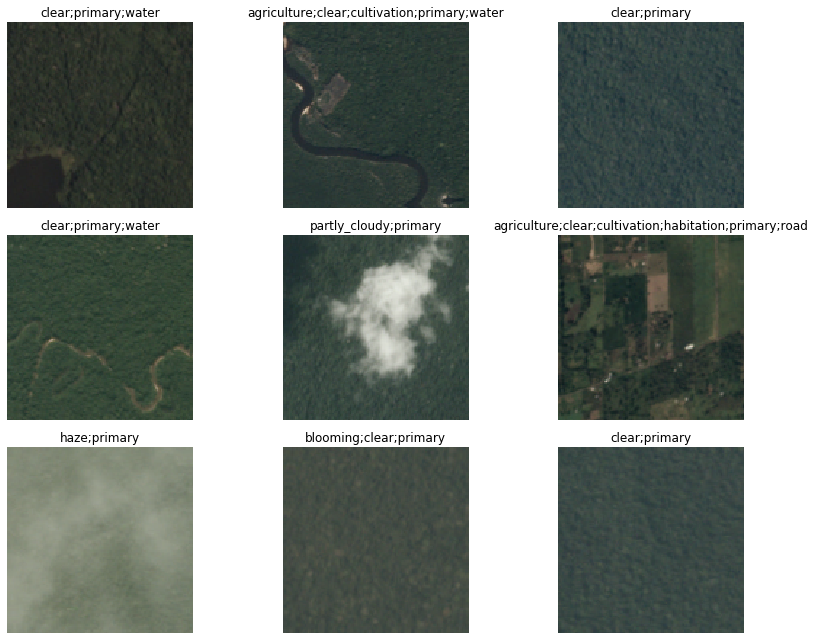

In [7]:
data.show_batch(rows=3, figsize=(12,9))

In [8]:
accuracy_thresh?

Signature:
accuracy_thresh(
    y_pred: torch.Tensor,
    y_true: torch.Tensor,
    thresh: float = 0.5,
    sigmoid: bool = True,
) -> <function NewType.<locals>.new_type at 0x7f00f91ed670>
Docstring: Computes accuracy when `y_pred` and `y_true` are the same size.
File:      ~/.pyenv/versions/3.8.1/envs/py38/lib/python3.8/site-packages/fastai/metrics.py
Type:      function


In [9]:
fbeta?

Signature:
fbeta(
    y_pred: torch.Tensor,
    y_true: torch.Tensor,
    thresh: float = 0.2,
    beta: float = 2,
    eps: float = 1e-09,
    sigmoid: bool = True,
) -> <function NewType.<locals>.new_type at 0x7f00f91ed670>
Docstring: Computes the f_beta between `preds` and `targets`
File:      ~/.pyenv/versions/3.8.1/envs/py38/lib/python3.8/site-packages/fastai/metrics.py
Type:      function


In [10]:
accuracy_02 = partial(accuracy_thresh, thresh=0.2)
fbeta_02 = partial(fbeta, thresh=0.2)

In [11]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy_02, fbeta_02])
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


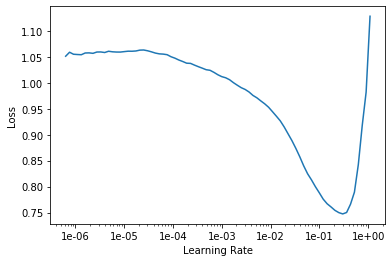

In [12]:
learn.recorder.plot()

In [13]:
lr = 1e-2

In [14]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.133888,0.118728,0.943066,0.899583,00:46
1,0.113479,0.101475,0.952985,0.913161,00:46
2,0.103824,0.092784,0.955673,0.920712,00:45
3,0.094710,0.088743,0.954235,0.923373,00:46
4,0.091657,0.087160,0.957228,0.925706,00:45


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


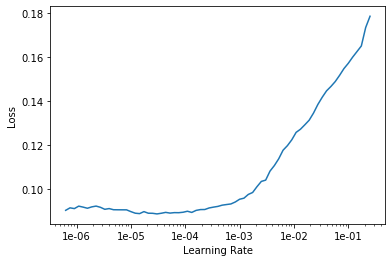

In [15]:
# now we unfreeze, find lr again, and run one more cycle
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.100728,0.095203,0.952251,0.918449,00:53
1,0.096487,0.090181,0.955899,0.921260,00:53
2,0.091568,0.086100,0.955630,0.926027,00:53
3,0.084335,0.083148,0.958500,0.928599,00:53
4,0.082282,0.082594,0.958086,0.928295,00:53


In [17]:
learn.save('stage-2-128')

# now we use data with image size 256
data = (src
            .transform(tfms, size=256)  # size is image size
            .databunch()
            .normalize(imagenet_stats))
learn.data = data

# freeze, and re-learn
learn.freeze()
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


AttributeError: 'float' object has no attribute 'recorder'

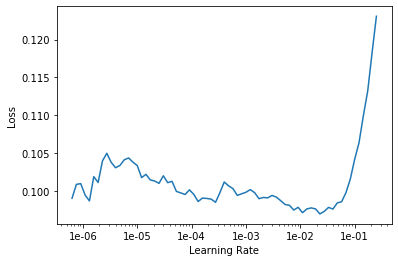

In [18]:
learn.recorder.plot()

In [19]:
lr = 1e-2 / 2  # a little before 1e-2

In [20]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.088671,0.084943,0.956843,0.926901,01:41
1,0.086126,0.084029,0.958645,0.928073,01:40
2,0.085658,0.081871,0.957425,0.930337,01:40
3,0.085057,0.081411,0.958900,0.931040,01:40
4,0.081195,0.081261,0.959227,0.929995,01:40


In [21]:
learn.save('stage-1-256')

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


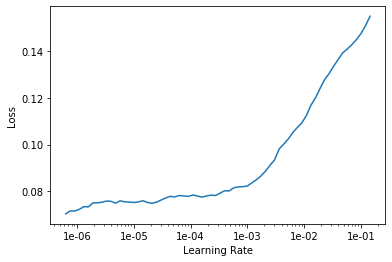

In [23]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))  # will this work??

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.081843,0.084213,0.958435,0.928165,02:11
1,0.083903,0.083754,0.959372,0.929597,02:11
2,0.082752,0.082751,0.956982,0.929634,02:11
3,0.075206,0.080844,0.959670,0.930720,02:11
4,0.075954,0.080844,0.960208,0.931095,02:11


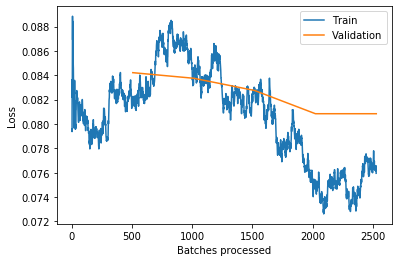

In [25]:
# huh, the LR was on an upward trend in the plot, but it still helped
learn.recorder.plot_losses()

In [27]:
learn.save('stage-2-256')